Dieses Beispiel wurde inspiriert von Tensorflow https://www.tensorflow.org/datasets/keras_example

In [25]:
# Importiert die Bibliotheken tensorflow welche für das maschinelle Lernen
# eingesetzt wird als tf und die Beispieldatensätze als tfds.
import tensorflow as tf
import tensorflow_datasets as tfds

In [26]:
# Als ersten Schritt in der Deeplearning-Pipeline laden wir die Daten
# vom Datensatz und teilen sie in Trainings- und Testdatensätze auf.
# Diese Teilung garantiert, dass das Modell auch auf neue Daten, welche
# es zuvor noch nie gesehen hat, evaluiert werden kann.
(ds_train, ds_test), ds_info = tfds.load(
  'mnist',
  split=['train', 'test'],
  shuffle_files=True,
  as_supervised=True,
  with_info=True,
)

Der MNIST Datensätz enthhält Bilder, in Graustufen, der 10 Zahlen 0,...,9 in Handschrift. Das Ziel ist es meist, den Bildern die richtige Zahl zuzuordnen. Damit befinden wir uns in der Klassifizierung.

In [27]:
# Geben wir die Datensätze aus, erhalten wir mehr Informationen über die Daten.
# Wir wissen nun etwa, dass es sich bei den Bildern um 28 x 28 Bilder handelt.
print(ds_train)
print(ds_test)

<_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


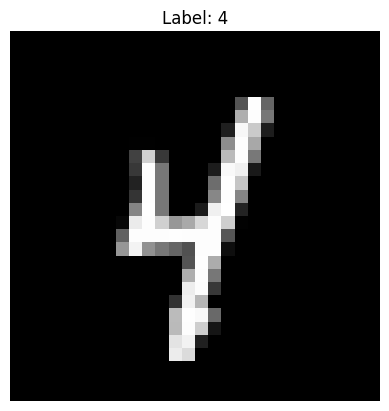

In [28]:
# Schauen wir uns doch einmal eines der Bilder an
import matplotlib.pyplot as plt

# Mit .take können wir n mal aus dem Datensatz ziehen und die Bilder und Labels
# anschließend zum Anzeigen konvertieren und mit Matplotlib ausgeben.
for image, label in ds_train.take(1):
  image = image.numpy()
  label = label.numpy()

  plt.imshow(image, cmap='gray')
  plt.title(f"Label: {label}")
  plt.axis('off')
  plt.show()

In [29]:
def crop_and_resize(image, target_size=(28, 28)):
    """
    Konvertiert das Bild zu Schwarz-Weiß, schneidet Ränder weg und bringt es
    in die richtigen Dimensionen.

    Args:
        image (tf.Tensor): Ein zwei dimensionaler Tensor,
                          welcher ein Graustufen Bild abbildet. (Werte 0-255).
        target_size (tuple): Die gewünschte Bildgröße (default: (28, 28)).

    Returns:
        tf.Tensor: Das verkleinerte, graustufen Bild in der gewünschten Größe.
    """

    # Suche nach allen Pixeln die nicht schwarz sind.
    non_zero_pixels = tf.where(image > 0)

    # Suche nach der Bounding Box des Symbols.
    min_row = tf.reduce_min(non_zero_pixels[:, 0])
    max_row = tf.reduce_max(non_zero_pixels[:, 0])
    min_col = tf.reduce_min(non_zero_pixels[:, 1])
    max_col = tf.reduce_max(non_zero_pixels[:, 1])

    # Zuschneiden des Bildes. (Entfernen unnötiger Pixel am Rand.)
    cropped_image = image[min_row:max_row + 1, min_col:max_col + 1]

    # Prüfen ob das Bild noch Pixel enthält, sonst leeres Bild zurück geben.
    if tf.size(cropped_image) == 0:
        return tf.zeros(target_size, dtype=tf.uint8)

    # Bild in gewünschte Größe transformieren.
    resized_image = tf.image.resize(
        cropped_image,
        target_size,
        method='bilinear'
    )

    # Entfernen unnötiger Dimensionen.
    resized_image = tf.squeeze(resized_image)

    # Umwandeln des Bildes in Schwarz/Weiß (binär)
    binary_image = tf.where(resized_image > 0, 1, 0)

    return tf.cast(binary_image, tf.uint8)

def normalize_img(image, label):
  """Normalisiert das Bild: `grayscale` -> `black and white`."""
  image = crop_and_resize(image, (28, 28))

  return image, label

In [30]:
#Hyperparameters
LEARNING_RATE = 0.02 # Die Lernrate.
EPOCHS = 3 # Die Anzahl der zu trainierenden Epochen

In [31]:
# Diese Pipeline kümmert sich um die Normalisierung der Bilder
ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.batch(1)

# Die Beispiele werden durchmischt, damit keine versteckte Ordnung hinter den
# Daten herrscht, z.B. zuerst Hunde dann Katzen. Eine solche Ordnung könnte das
# Training des Netzwerkes behindern.
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.cache()
ds_test = ds_test.batch(1)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [32]:
# Erstellen des Modells basierend auf den Parametern
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(28, 28), name="Input"),
  tf.keras.layers.Flatten(name="Flatten"),
  tf.keras.layers.Dense(48, name="FirstLayer"),
  tf.keras.layers.Activation("relu", name="ReLu"),
  tf.keras.layers.Dense(10, name="SecondLayer"),
  tf.keras.layers.Activation("softmax", name="Softmax")
])

# Anzeigen der Zusammenfassung des Modells.
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FirstLayer (Dense)              │ (None, 48)             │        37,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ReLu (Activation)               │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ SecondLayer (Dense)             │ (None, 10)             │           490 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Softmax (Activation)            │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,170 (149.10 KB)

 Trainable params: 38,170 (149.10 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# Hier wird das Modell und seine Parameter erstellt.
model.compile(
    optimizer=tf.keras.optimizers.SGD(LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    # Die Wahrscheinlichkeit, dass eine Ziffer richtig zugeordnet wird.
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [34]:
# Das Modell beginnt hier zu lernen.
model.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_test,
)

Epoch 1/3
60000/60000 ━━━━━━━━━━━━━━━━━━━━ 160s 2ms/step - loss: 0.7499 - sparse_categorical_accuracy: 0.7794 - val_loss: 0.4919 - val_sparse_categorical_accuracy: 0.8964
Epoch 2/3
60000/60000 ━━━━━━━━━━━━━━━━━━━━ 148s 2ms/step - loss: 0.5441 - sparse_categorical_accuracy: 0.8697 - val_loss: 0.4348 - val_sparse_categorical_accuracy: 0.8936
Epoch 3/3
60000/60000 ━━━━━━━━━━━━━━━━━━━━ 146s 2ms/step - loss: 0.4924 - sparse_categorical_accuracy: 0.8824 - val_loss: 0.5272 - val_sparse_categorical_accuracy: 0.9002


In [35]:
# Das trainierte Modell kann nochmals mit den Daten aus dem Testdatensatz
# evaluiert werden.
model.evaluate(ds_test)

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.5081 - sparse_categorical_accuracy: 0.8997


[0.5272156000137329, 0.9002000093460083]

In [36]:
# Hier können das Modell oder nur die Gewichte gespeichert werden.
# Später, wie du schon weißt, kann das Modell von diesen Dateien geladen werden.
model.save("mnist.keras")
model.save_weights("mnist.weights.h5")

In [37]:
# Hier laden wir ein Repository, um das Zeichnen in Colab zu ermöglichen.
!git clone https://gist.github.com/8409b3feec20f159d8a50b0a811d3bca.git

%run /content/8409b3feec20f159d8a50b0a811d3bca/draw.py

draw(filename = "your_drawing.png", w=400, h=400, line_width=64)

fatal: destination path '8409b3feec20f159d8a50b0a811d3bca' already exists and is not an empty directory.


10187

<Figure size 640x480 with 0 Axes>

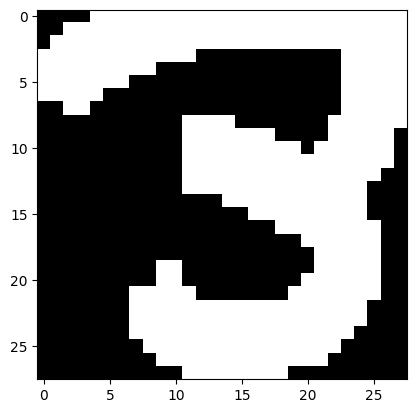

In [38]:
# Nun können wir das Bild laden und es in die richtige Größe transformieren.
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread("your_drawing.png", cv2.IMREAD_UNCHANGED)
alpha = img[:, :, 3]
img = np.zeros_like(alpha)
img[alpha > 0] = 255

img = np.expand_dims(img, axis=-1)

# Da der Input des Neuronalen Netzwerkes während des Trainings normalisiert wurde,
# können wir dies auch hier durchführen. [0,255] -> [0; 1]
img, _ = normalize_img(img, 0)
plt.imshow(img, cmap="gray")

In [39]:
import math

# Vorhersagen der richtigen Zahl.
img_exp = np.expand_dims(img, axis=0)
pred = model.predict(img_exp)

# Anzeigen als Balkendiagramm
for i in range(0, 10):
  print(f"{i}: {'■' * int(pred[0][i]*100)} {round(pred[0][i]*100,2)}%")

print("Zahl: ", np.argmax(pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
0:  0.0%
1:  0.0%
2:  0.0%
3: ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 100.0%
4:  0.0%
5:  0.0%
6:  0.0%
7:  0.0%
8:  0.0%
9:  0.0%
Zahl:  3
